In [0]:
# The following implementation is adapted from Google online ML Course, 'Sparse Data and Embeddings' section
#
# The data is obtained from : http://ai.stanford.edu/~amaas/data/sentiment/
#
# Tensorflow library is used for the following analysis

In [0]:
from __future__ import print_function

import collections
import io
import math

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython import display
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)
train_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/train.tfrecord'
train_path = tf.keras.utils.get_file(train_url.split('/')[-1], train_url)
test_url = 'https://download.mlcc.google.com/mledu-datasets/sparse-data-embedding/test.tfrecord'
test_path = tf.keras.utils.get_file(test_url.split('/')[-1], test_url)

In [0]:
# GOAL 
# 1) to convert movie-review data into sparse feature vector
# 2) implement sentiment analysis with DNN model
# 3) Visualize what the model has learned using Word Embeddings

In [0]:
def _parse_function(record):
  
  features = {
    "terms": tf.VarLenFeature(dtype=tf.string), # terms are strings of varying lengths
    "labels": tf.FixedLenFeature(shape=[1], dtype=tf.float32) # labels are 0 or 1
  }
  
  parsed_features = tf.parse_single_example(record, features)
  
  terms = parsed_features['terms'].values
  labels = parsed_features['labels']

  return  {'terms':terms}, labels

In [5]:
# testing the funtion cell
ds = tf.data.TFRecordDataset(train_path)
ds = ds.map(_parse_function)
ds

<DatasetV1Adapter shapes: ({terms: (?,)}, (1,)), types: ({terms: tf.string}, tf.float32)>

In [6]:
# Retrieving the example train data set
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'terms': array([b'but', b'it', b'does', b'have', b'some', b'good', b'action',
         b'and', b'a', b'plot', b'that', b'is', b'somewhat', b'interesting',
         b'.', b'nevsky', b'acts', b'like', b'a', b'body', b'builder',
         b'and', b'he', b'isn', b"'", b't', b'all', b'that', b'attractive',
         b',', b'in', b'fact', b',', b'imo', b',', b'he', b'is', b'ugly',
         b'.', b'(', b'his', b'acting', b'skills', b'lack', b'everything',
         b'!', b')', b'sascha', b'is', b'played', b'very', b'well', b'by',
         b'joanna', b'pacula', b',', b'but', b'she', b'needed', b'more',
         b'lines', b'than', b'she', b'was', b'given', b',', b'her',
         b'character', b'needed', b'to', b'be', b'developed', b'.',
         b'there', b'are', b'way', b'too', b'many', b'men', b'in', b'this',
         b'story', b',', b'there', b'is', b'zero', b'romance', b',', b'too',
         b'much', b'action', b',', b'and', b'way', b'too', b'dumb', b'of',
         b'an', b'ending', b'.', b'

In [0]:
#Create an input_fn 
# The funtion will parse and then split into The Features vs. Targets

def _input_fn(input_filenames, num_epochs = None, shuffle =  True):
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)
    
    if shuffle:
        ds = ds.shuffle(10000)
        
    ds = ds.padded_batch(25, ds.output_shapes)
    
    ds = ds.repeat(num_epochs)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels


In [0]:
# USING LINEAR MODEL 
#
# Define categorical list 
informative_terms  = ("bad", "great", "best", "worst", "fun", "beautiful",
                     "excellent", "poor", "boring", "awful", "terrible",
                     "definitely", "perfect", "liked", "worse", "waste",
                     "entertaining", "loved", "unfortunately", "amazing",
                     "enjoyed", "favorite", "horrible", "brilliant", "highly",
                     "simple", "annoying", "today", "hilarious", "enjoyable",
                     "dull", "fantastic", "poorly", "fails", "disappointing",
                     "disappointment", "not", "him", "her", "good", "time",
                     "?", ".", "!", "movie", "film", "action", "comedy",
                     "drama", "family")
terms_feature_column = tf.feature_column.categorical_column_with_vocabulary_list(key="terms", vocabulary_list=informative_terms)

In [10]:
# USING DNN CLASSIFIER 

classifier2 = tf.estimator.DNNClassifier( 
  feature_columns=[tf.feature_column.indicator_column(terms_feature_column)], #
  hidden_units=[20,20],                                                       #
  optimizer=my_optimizer,                                                     #
)                                                                             #
###############################################################################

try:
  classifier2.train( input_fn=lambda: _input_fn([train_path]), steps=1000)

  evaluation_metrics = classifier2.evaluate(input_fn=lambda: _input_fn([train_path]), steps=1)
  print("Training set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")

  evaluation_metrics = classifier2.evaluate( input_fn=lambda: _input_fn([test_path]),steps=1)

  print("Test set metrics:")
  for m in evaluation_metrics:
    print(m, evaluation_metrics[m])
  print("---")
except ValueError as err:
  print(err)

Training set metrics:
accuracy 0.76
accuracy_baseline 0.6
auc 0.8533333
auc_precision_recall 0.821755
average_loss 0.5136773
label/mean 0.4
loss 12.841932
precision 0.64285713
prediction/mean 0.51104754
recall 0.9
global_step 1000
---
Test set metrics:
accuracy 0.68
accuracy_baseline 0.6
auc 0.78666663
auc_precision_recall 0.6372257
average_loss 0.567432
label/mean 0.4
loss 14.1858
precision 0.625
prediction/mean 0.35065052
recall 0.5
global_step 1000
---


In [11]:
# Using EMBEDDING COLUMNS
# Note:: An embedding column takes sparse data as input 
#    and returns a low dimensional (dense) vector as output

terms_embedding_column = tf.feature_column.embedding_column(terms_feature_column, dimension=2)
feature_columns = [ terms_embedding_column ]

my_optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)

classifierE = tf.estimator.DNNClassifier(
  feature_columns=feature_columns,
  hidden_units=[20,20],
  optimizer=my_optimizer
)
#################################################################################

classifierE.train(input_fn=lambda: _input_fn([train_path]), steps=1000)

evaluation_metrics = classifierE.evaluate(input_fn=lambda: _input_fn([train_path]),steps=1000)
print("Training set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---"*10)

evaluation_metrics = classifierE.evaluate(  input_fn=lambda: _input_fn([test_path]), steps=1000)

print("Test set metrics:")
for m in evaluation_metrics:
  print(m, evaluation_metrics[m])
print("---"*10)

Training set metrics:
accuracy 0.77908
accuracy_baseline 0.5
auc 0.86841434
auc_precision_recall 0.857063
average_loss 0.46286833
label/mean 0.5
loss 11.571708
precision 0.73202527
prediction/mean 0.5522257
recall 0.88048
global_step 1000
------------------------------
Test set metrics:
accuracy 0.77848
accuracy_baseline 0.5
auc 0.86783236
auc_precision_recall 0.8564199
average_loss 0.46362504
label/mean 0.5
loss 11.590626
precision 0.7328117
prediction/mean 0.5510567
recall 0.87656
global_step 1000
------------------------------


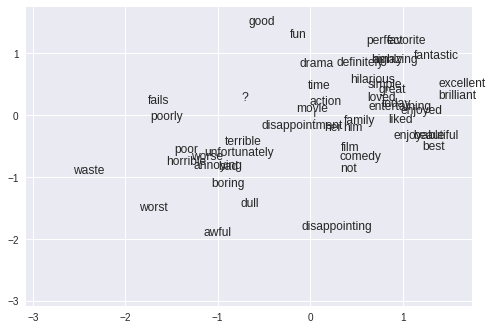

In [12]:
import numpy as np
import matplotlib.pyplot as plt

embedding_matrix = classifierE.get_variable_value('dnn/input_from_feature_columns/input_layer/terms_embedding/embedding_weights')

for term_index in range(len(informative_terms)):
  # Create a one-hot encoding for our term. It has 0s everywhere, except for
  # a single 1 in the coordinate that corresponds to that term.
  term_vector = np.zeros(len(informative_terms))
  term_vector[term_index] = 1
  # We'll now project that one-hot vector into the embedding space.
  embedding_xy = np.matmul(term_vector, embedding_matrix)
  plt.text(embedding_xy[0],
           embedding_xy[1],
           informative_terms[term_index])

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.ylim(1.2 * embedding_matrix.min(), 1.2 * embedding_matrix.max())
plt.show() 